# Genre Classification using Supervised Machine Learning Models

This notebook contains the code to classify tracks with a genre by (1) investigating possible predictive input features and (2) predicting genre labels using 3 supervised classification models: K-Nearest Neighbors (KNN), support vector machines (SVM) and random forest (RF).


> **Highly recommended**: Install [sklearn-intelex](https://pypi.org/project/scikit-learn-intelex/) to speed up model training especially for low-spec machines

In [2]:
!pip install scikit-optimize -q
!pip install imblearn -q
!pip install xgboost -q
!pip install shap -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.0 which is incompatible.
sagemaker-datawran

In [3]:
# general libraries
import warnings
import time
import shap
import os
import pickle
import requests
import joblib
from tqdm import tqdm
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict
warnings.filterwarnings("ignore")

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Resampling
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, SMOTENC, SMOTEN, ADASYN, SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
from imblearn.combine import SMOTETomek, SMOTEENN

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
from nltk.corpus import stopwords

# Outlier detection
import scipy.stats as stats
from sklearn.ensemble import IsolationForest

# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
import xgboost as xgb

In [4]:
# Utility methods
def evaluate_base_models(X, y, sampling_technique=None, override_models=None, scaler=None, n_splits=5, sort_by_value='ave_val_acc'):
    random_state = 42

    models = {
        # 'KNN': KNeighborsClassifier(n_jobs=-1),
        'Logistic Regression': LogisticRegression(random_state=random_state, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'ExtraTrees': ExtraTreesClassifier(random_state=random_state),
        'XGBoost': xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y)), random_state=42)
    }

    if override_models:
        models = override_models

    skf = StratifiedKFold(n_splits=n_splits)
    res = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models.items()):
        train_scores, val_scores = [], []
        train_prec, val_prec = [], []
        train_rec, val_rec = [], []
        train_f1, val_f1 = [], []
        train_fbeta, val_fbeta = [], []
        results = {
            'train_scores': [],
            'val_scores': [],
            'train_prec': [],
            'val_prec': [],
            'train_rec': [],
            'val_rec': [],
            'train_f1': [],
            'val_f1': [],
            'y_train': [],
            'y_val': [],
            'train_preds': [],
            'val_preds': []
        }

        steps = []
        if scaler:
            steps.append(scaler)

        if sampling_technique:
            steps.append(sampling_technique)

        steps.append(model)

        pipeline = make_pipeline(*steps)

        start_time = time.time()
        for train_index, val_index in tqdm(skf.split(X_trainval, y_trainval)):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            pipeline.fit(X_train, y_train)

            train_score = pipeline.score(X_train, y_train)
            val_score = pipeline.score(X_val, y_val)

            train_preds = pipeline.predict(X_train)
            val_preds = pipeline.predict(X_val)

            results['train_scores'].append(train_score)
            results['val_scores'].append(val_score)
            results['train_prec'].append(precision_score(y_train, train_preds, average='weighted'))
            results['val_prec'].append(precision_score(y_val, val_preds, average='weighted'))
            results['train_rec'].append(recall_score(y_train, train_preds, average='weighted'))
            results['val_rec'].append(recall_score(y_val, val_preds, average='weighted'))
            results['train_f1'].append(f1_score(y_train, train_preds, average='weighted'))
            results['val_f1'].append(f1_score(y_val, val_preds, average='weighted'))
            results['y_train'].append(y_train)
            results['y_val'].append(y_val)
            results['train_preds'].append(train_preds)
            results['val_preds'].append(val_preds)

        end_time = time.time()
        res[model_name] = {
            'scaling': type(scaler).__name__ if scaler else 'None',
            'resampling_technique': type(sampling_technique).__name__ if sampling_technique else 'None',
            'ave_train_acc': np.mean(results['train_scores']) * 100,
            'ave_val_acc': np.mean(results['val_scores']) * 100,
            'ave_train_prec': np.mean(results['train_prec']) * 100,
            'ave_val_prec': np.mean(results['val_prec']) * 100,
            'ave_train_rec': np.mean(results['train_rec']) * 100,
            'ave_val_rec': np.mean(results['val_rec']) * 100,
            'ave_train_f1': np.mean(results['train_f1']) * 100,
            'ave_val_f1': np.mean(results['val_f1']) * 100,
            'run_time': end_time - start_time,
            'results' : results
        }

    total_end = time.time()
    elapsed = total_end - total_start
    print(f"Report Generated in {elapsed:.2f} seconds")
    report = pd.DataFrame(res).T.sort_values(by=sort_by_value, ascending=False)
    return report

def evaluate_sampling_techniques(X_trainval, y_trainval, use_sampling=True, scaler=None, random_state=42):
    sampling_techniques = {
        'SMOTE': SMOTE(random_state=random_state, n_jobs=-1),
        'ADASYN': ADASYN(random_state=random_state, n_jobs=-1),
        # 'BorderlineSMOTE': BorderlineSMOTE(random_state=random_state, n_jobs=-1),
        'NearMiss': NearMiss(n_jobs=-1),
        'TomekLinks': TomekLinks(n_jobs=-1),
        'SMOTETomek': SMOTETomek(random_state=random_state, n_jobs=-1),
        'SMOTEENN': SMOTEENN(random_state=random_state, n_jobs=-1)
    }

    # Dictionary to hold DataFrames for each sampling technique
    sampling_reports = defaultdict(pd.DataFrame)

    if use_sampling:
        for technique_name, technique in sampling_techniques.items():
            print(f"Evaluating models with {technique_name} sampling technique with {scaler.__class__.__name__ if scaler else 'No scaling'}...")
            report = evaluate_base_models(X_trainval, y_trainval, sampling_technique=technique, scaler=scaler).sort_values(by='ave_val_acc', ascending=False)
            print(report)
            sampling_reports[technique_name] = report
    else:
        sampling_reports[technique_name] = evaluate_base_models(X_trainval, y_trainval, scaler=scaler).sort_values(by='ave_val_acc', ascending=False)

    sampling_reports_df = pd.concat(sampling_reports, names=['Sampling Technique', 'Model']).reset_index()

    return sampling_reports_df

def tune_top_models(X, y, top_algorithms, sampling_technique, scorer='accuracy', n_splits=3):
    random_state = 42

    models_and_grids = {
     'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'p': [1, 2]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=random_state),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'class_weight': ['balanced', None],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'fit_intercept': [True, False],
            'dual': [True, False],
            'max_iter': [50, 100, 200],
            'multi_class': ['auto', 'ovr', 'multinomial'],
            'l1_ratio': [None, 0.25, 0.5, 0.75],
            'warm_start': [True, False],
            'verbose': [0, 1]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'params': {
            'splitter': ['best', 'random'],
            'max_depth': [8, 12, 16, 20],
            'min_samples_split': [5, 10, 15, 20],
            'max_features': [None, 'sqrt', 'log2'],
            'criterion': ['gini', 'entropy'],
            'class_weight' : ['balanced', None]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=random_state),
        'params': {
            'n_estimators': [100, 150, 200, 250],
            'learning_rate': [0.001, 0.01, 0.1, 1],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y)), random_state=random_state),
        'params': {
            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
            'n_estimators': [50, 100, 150, 200, 250],
            'max_depth': [2, 3, 5, 7, 9],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 3, 4],
            'criterion': ['squared_error', 'friedman_mse']
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy']
        }
    }
  }

    print(f'The top algorithms are: {top_algorithms}')

    params_and_metrics = {}

    for name in top_algorithms:
        mg = models_and_grids.get(name)
        model = mg['model']
        params = mg['params']
        print(f'Tuning for {name}')

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        pipeline = Pipeline([
            ('Scaling', StandardScaler()),
            ('Sampler', sampling_technique),
            ('Model', model)
        ])

        # Update the parameter grid to work with pipeline
        params = {f'Model__{key}': params[key] for key in params}

        # Bayesian optimization
        bayes_clf = BayesSearchCV(pipeline, params, cv=StratifiedKFold(n_splits=n_splits), n_iter=20, scoring=scorer, n_jobs=-1, verbose=0)
        start = time.time()

        bayes_clf.fit(X_train, y_train)

        end = time.time()

        # Extract results
        best_model = bayes_clf.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_test)

        train_accuracy = accuracy_score(y_train, train_pred)
        val_accuracy = accuracy_score(y_test, val_pred)
        train_recall = recall_score(y_train, train_pred, average='weighted')
        val_recall = recall_score(y_test, val_pred, average='weighted')

        # Additional metrics
        train_f1 = f1_score(y_train, train_pred, average='weighted')
        val_f1 = f1_score(y_test, val_pred, average='weighted')
        train_precision = precision_score(y_train, train_pred, average='weighted')
        val_precision = precision_score(y_test, val_pred, average='weighted')

        params_and_metrics[name] = {
            'best_params': bayes_clf.best_params_,
            'train_accuracy': train_accuracy,
            'test_accuracy': val_accuracy,
            'train_recall': train_recall,
            'test_recall': val_recall,
            'train_precision': train_precision,  # Added
            'test_precision': val_precision,  # Added
            'train_f1': train_f1,  # Added
            'val_f1': val_f1,  # Added
            'runtime': end - start,
        }

    params_and_metrics = pd.DataFrame(params_and_metrics)
    return params_and_metrics.T

def url_exists(url):
    try:
        response = requests.head(url)
        return response.status_code == 200
    except:
        return False

def is_url(string):
    return string.startswith("http://") or string.startswith("https://")

def load_or_run(filepath, func, *args, **kwargs):
    if (is_url(filepath) and url_exists(filepath)) or os.path.exists(filepath):
        dataframe = pd.read_csv(filepath)
    else:
        dataframe = func(*args, **kwargs)
        dataframe.to_csv(filepath)
    return dataframe

def plot_line_comparison_models(df, metric, title, xlabel, ylabel):
    pivot_df = df.pivot(index='Sampling Technique', columns='Model', values=metric)

    # Plotting
    plt.figure(figsize=(14, 8))

    # Determine the appropriate color map based on the number of columns
    num_columns = len(pivot_df.columns)
    if num_columns <= 10:
        colormap = plt.cm.tab10
    elif num_columns <= 20:
        colormap = plt.cm.tab20
    else:
        colormap = plt.cm.viridis

    unique_colors = colormap(np.linspace(0, 1, num_columns))

    # Use the palette in the plot
    for i, (column, color) in enumerate(zip(pivot_df.columns, unique_colors)):
        plt.plot(pivot_df.index, pivot_df[column], marker='o', label=column, color=color)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_bar_comparison_models(df, metric, title, xlabel, ylabel):
    # Create a new column that combines "Model" and "Sampling Technique"
    df['Model_Sampling'] = df['Model'] + ' + ' + df['Sampling Technique']

    # Sort the DataFrame based on the metric
    df_sorted = df.sort_values(by=metric)

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.barh(df_sorted['Model_Sampling'], df_sorted[metric], color='#90EE90')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

def plot_clustered_barh(df_with_sampling, df_without_sampling, metric, xlabel):
    df = pd.concat([df_with_sampling, df_without_sampling])

    df['Model_Sampling'] = df['Model'] + ' with ' + df['Sampling Technique']

    sorted_models = df_with_sampling.sort_values(by=metric, ascending=True)['Model'].tolist()

    plt.figure(figsize=(10, 8))

    y_pos = 0

    color_with_sampling = plt.cm.Blues(0.6)  # Fixed color for models with sampling
    color_without_sampling = plt.cm.Reds(0.6)  # Fixed color for models without sampling

    for model in sorted_models:
        subset_without = df[(df['Model'] == model) & (df['Sampling Technique'] == 'No Sampling')]
        subset_with = df[(df['Model'] == model) & (df['Sampling Technique'] != 'No Sampling')]

        y_labels_without = subset_without['Model_Sampling']
        x_values_without = subset_without[metric]
        plt.barh(y_labels_without, x_values_without, color=color_without_sampling)

        y_labels_with = subset_with['Model_Sampling']
        x_values_with = subset_with[metric]
        plt.barh(y_labels_with, x_values_with, color=color_with_sampling)

        for i, val in enumerate(x_values_without):
            plt.text(val - 6, y_pos + i, f"{val:.2f}%", va='center', color='white', fontsize=9)

        for i, val in enumerate(x_values_with):
            plt.text(val - 6, y_pos + i + len(x_values_without), f"{val:.2f}%", va='center', color='white', fontsize=9)

        y_pos += len(subset_with) + len(subset_without)

    plt.xlabel(xlabel)
    plt.ylabel('Model')
    plt.show()


def plot_model_base_hypertuned_comparison(title, baseline_recall, baseline_fbeta, hypertuned_recall, hypertuned_fbeta):
    labels = ['Recall', 'F-Beta']
    baseline_scores = [baseline_recall, baseline_fbeta]
    hypertuned_scores = [hypertuned_recall, hypertuned_fbeta]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()

    rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='#add8e6')
    rects2 = ax.bar(x + width/2, hypertuned_scores, width, label='Hypertuned', color='#ffcccb')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 20 points vertical offset from the top of the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 20 points vertical offset from the top of the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()


def evaluate_model(model, X_trainval, y_trainval, X_holdout, y_holdout, target_names,
                   scaler=None, sampling_technique=None, features=None, filename=None):
    
    if features:
        X_trainval = X_trainval[features]
        X_holdout = X_holdout[features]

    steps = []
    if scaler:
        steps.append(('scaler', scaler))
    if sampling_technique:
        steps.append(('sampler', sampling_technique))
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    pipeline.fit(X_trainval, y_trainval)

    if filename:
        joblib.dump(pipeline, filename + '.pkl')

    y_pred = pipeline.predict(X_holdout)

    print("Classification Report:")
    print(classification_report(y_holdout, y_pred, target_names=target_names))
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_holdout, y_pred)
    print(conf_matrix)
    ConfusionMatrixDisplay(conf_matrix, display_labels=target_names).plot(cmap='Blues', values_format='.0f')
    plt.title('Confusion Matrix')
    plt.show()

    y_train_preds = pipeline.predict(X_trainval)
    train_recall = recall_score(y_trainval, y_train_preds, average='weighted')
    test_recall = recall_score(y_holdout, y_pred, average='weighted')
    precision = precision_score(y_holdout, y_pred, average='weighted')
    f1 = f1_score(y_holdout, y_pred, average='weighted')
    train_accuracy = accuracy_score(y_trainval, y_train_preds)
    test_accuracy = accuracy_score(y_holdout, y_pred)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print(f"Training Recall: {train_recall}")
    print(f"Test Recall: {test_recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")

    return pipeline, test_accuracy

In [ ]:
# # Mount GDrive folders
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Set home directory
# import os
# home_dir = "/content/drive/MyDrive/Colab Notebooks/Sprint 3/"
# os.chdir(home_dir)

In [5]:
DIRECTORY = 'https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/'

## 1. Read and check values of playlist sets

### 1.1. Set genres for prediction

In [6]:
genre_names = ['alternative_rock', 'sad_opm', 'pop']
# genre_names = ["Alternative Rock", "Hip-Hop", 'EDM', 'OPM']

### 1.2. Read and check tracks data for each genre

Collect genre playlist data

In [8]:
playlist_df_list = []
for genre in tqdm(genre_names):
    filename = DIRECTORY +genre.lower()+'_playlist_data.csv'
    print(filename)
    pdf = pd.read_csv(filename)
    pdf['genre'] = genre.lower()
    playlist_df_list.append(pdf)

 33%|███▎      | 1/3 [00:00<00:00,  9.61it/s]

https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/alternative_rock_playlist_data.csv
https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/sad_opm_playlist_data.csv
https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/pop_playlist_data.csv


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


Collect genre track data

In [9]:
track_df_list = []
for genre in tqdm(genre_names):
    tdf = pd.read_csv(DIRECTORY+genre.lower()+'_playlist_tracks_data.csv')
    tdf = tdf[~tdf.duplicated(subset=['track_id'])] # keep only 1 track id, relevant for older playlist data
    tdf['genre'] =  genre.lower()
    track_df_list.append(tdf)

100%|██████████| 3/3 [00:00<00:00,  5.74it/s]


Concatenate playlist data

In [10]:
playlist_df = pd.concat(playlist_df_list)
playlist_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,20LKsiDZd4ALrlihncFcFa,90s ALTERNATIVE ROCK,161,myplay.com,Filtr US,754307,alternative_rock
1,37i9dQZF1DXcKHVXMYcCuJ,Alternative Rock's Most Precious Gems,150,spotify,Spotify,140628,alternative_rock
2,2VCUG2HWlEeq1zvUvRkN80,2000s Alternative Rock,130,ltxteis,LtX,89524,alternative_rock
3,7xY8wHHjF0wxke2dkK3sRc,90's Alternative Rock (Top 100),146,tdkqms1h1k98zcv23ug77vcb1,a.j.matthews16,71353,alternative_rock
4,5SMf1pyrOAwjwheZvHWkaj,Alternative Rock 90s 2000s Classics,110,tpfq85a51j5xg7andl6nuxdk8,Dad Money,59947,alternative_rock


In [11]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 89
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   playlist_id            157 non-null    object
 1   playlist_name          157 non-null    object
 2   playlist_total_tracks  157 non-null    int64 
 3   owner_id               157 non-null    object
 4   owner_name             157 non-null    object
 5   total_followers        157 non-null    int64 
 6   genre                  157 non-null    object
dtypes: int64(2), object(5)
memory usage: 9.8+ KB


Get genre playlist tally

In [12]:
playlist_df['genre'].value_counts()

pop                 90
alternative_rock    58
sad_opm              9
Name: genre, dtype: int64

Concatenate playlist data

In [13]:
tracks_df = pd.concat(track_df_list)
tracks_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre
0,2SrC3eKJkbnz4WWJufgBTS,0.488,0.870,6,-4.185,0,0.0421,0.003530,0.000000,0.484,...,187520,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,1,4qzWf7EmJKU7SHpf38zFX0,2022-10-21,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.125333,alternative_rock
1,60a0Rd6pjrkxjPbaKzXjfq,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.000000,0.209,...,216880,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,1,6hPkbAV3ZXpGZBGUvL6jVM,2000-10-24,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.614667,alternative_rock
2,6b2oQwSGFkzsMtQruIWm2p,0.515,0.430,7,-9.935,1,0.0369,0.010200,0.000141,0.129,...,238640,4Z8W4fKeB5YxbusRsdQVPb,Radiohead,1,6400dnyeDyD2mIFHfkwHXN,1993-02-22,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.977333,alternative_rock
3,6gVH9jHl5Xpxxl4gVVrEkE,0.410,0.964,7,-6.648,1,0.0763,0.000706,0.745000,1.000,...,285186,6olE6TJLqED3rqDCT0FyPh,Nirvana,1,01Z1nufhjxJVXVDuMRmNEM,2009-01-01,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,4.753100,alternative_rock
4,7AK0yeohL3m0N6l7GgzJhE,0.547,0.958,9,-2.448,0,0.1210,0.003500,0.000008,0.132,...,193100,0avNS76kgqKRDQZWMTpQey,Hurricane on Saturn,1,76Ou6hEBhZnDymZGVIrHOD,2023-04-18,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.218333,alternative_rock


In [14]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11977 entries, 0 to 7593
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          11977 non-null  object 
 1   danceability      11977 non-null  float64
 2   energy            11977 non-null  float64
 3   key               11977 non-null  int64  
 4   loudness          11977 non-null  float64
 5   mode              11977 non-null  int64  
 6   speechiness       11977 non-null  float64
 7   acousticness      11977 non-null  float64
 8   instrumentalness  11977 non-null  float64
 9   liveness          11977 non-null  float64
 10  valence           11977 non-null  float64
 11  tempo             11977 non-null  float64
 12  track_name        11977 non-null  object 
 13  popularity        11977 non-null  int64  
 14  duration_ms       11977 non-null  int64  
 15  artist_id         11977 non-null  object 
 16  artist_name       11977 non-null  object 

Get genre tracks tally

In [15]:
tracks_df['genre'].value_counts()

pop                 7594
alternative_rock    3866
sad_opm              517
Name: genre, dtype: int64

## 2. Refine the training data

**Refinement 1**

Get only *top 10 most followed playlists* per genre.

>Q: Try out keeping top 15 most followed playlists and see what results youll get.

In [16]:
#.head() will show top 10 followed playlists
# since playlists csv is already ordered by decreasing total followers
top_playlists_df = playlist_df.groupby(['genre']).head(15)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,20LKsiDZd4ALrlihncFcFa,90s ALTERNATIVE ROCK,161,myplay.com,Filtr US,754307,alternative_rock
1,37i9dQZF1DXcKHVXMYcCuJ,Alternative Rock's Most Precious Gems,150,spotify,Spotify,140628,alternative_rock
2,2VCUG2HWlEeq1zvUvRkN80,2000s Alternative Rock,130,ltxteis,LtX,89524,alternative_rock
3,7xY8wHHjF0wxke2dkK3sRc,90's Alternative Rock (Top 100),146,tdkqms1h1k98zcv23ug77vcb1,a.j.matthews16,71353,alternative_rock
4,5SMf1pyrOAwjwheZvHWkaj,Alternative Rock 90s 2000s Classics,110,tpfq85a51j5xg7andl6nuxdk8,Dad Money,59947,alternative_rock
5,3ZwGNZnttkwMhddDn3YzMF,BEST OF ALTERNATIVE ROCKS,196,12132181803,Maria Rezende Beirao,54856,alternative_rock
6,0TCbzzrT932hpTAKdKj8wM,90's/00's Alternative Rock,730,dolphinsfan49,dolphinsfan49,44139,alternative_rock
7,3oqK4QvwUBgTQ0lNpNef0S,Alternative Rock Playlist 2023 - Top New Alter...,20,redmusiccompany,redmusiccompany,30755,alternative_rock
8,6zSpW1JO6hStNiguLjkNP8,Chai's Best Alternative Rock,110,12139121519,Chai Razon Saturnino,15760,alternative_rock
9,1QlwZS4gfx0XepdxpBG1UH,Alternative Rock 2000s Music,70,klbhj1gdhd32ie7wcah3sw85r,Redlist - Power Songs,14791,alternative_rock


In [17]:
# Filter keeping only top 10 playlists
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]

In [18]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

alternative_rock    1347
pop                  807
sad_opm              517
Name: genre, dtype: int64

**Refinement 2**

Remove tracks that appear in different genre playlists - get only *unique tracks* per genre

In [19]:
# View duplicated
# Use artist id and track name to ensure uniqueness
tracks_df[tracks_df.duplicated(subset=['artist_id','track_name'])]

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre
149,2KVwlelhxKUy8LVV6JypH3,0.420,0.672,6,-7.902,1,0.0270,0.006700,0.000000,0.1080,...,238666,3Ngh2zDBRPEriyxQDAMKd1,Matchbox Twenty,1,4vUXTcKz7tXxrNl84meN6i,1996-10-01,3ZwGNZnttkwMhddDn3YzMF,BEST OF ALTERNATIVE ROCKS,3.977767,alternative_rock
168,4x3SQvTgvqSTU3nOL1urZh,0.473,0.643,4,-4.670,1,0.0293,0.013400,0.000000,0.1600,...,232800,2MqhkhX4npxDZ62ObR5ELO,Hoobastank,1,3wwRx7Tjr2BXD9Z4yGliie,2003-01-01,3ZwGNZnttkwMhddDn3YzMF,BEST OF ALTERNATIVE ROCKS,3.880000,alternative_rock
175,11bD1JtSjlIgKgZG2134DZ,0.563,0.592,9,-4.571,1,0.0276,0.209000,0.000051,0.1320,...,267933,3rIZMv9rysU7JkLzEaC5Jp,Snow Patrol,1,6fb7z9rBdrjzpBTg1R1Bwp,2006-01-01,3ZwGNZnttkwMhddDn3YzMF,BEST OF ALTERNATIVE ROCKS,4.465550,alternative_rock
230,7LVHVU3tWfcxj5aiPFEW4Q,0.209,0.417,3,-8.740,1,0.0338,0.164000,0.001960,0.1130,...,295533,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,1,4E7bV0pzG0LciBSWTszra6,2005-06-07,3ZwGNZnttkwMhddDn3YzMF,BEST OF ALTERNATIVE ROCKS,4.925550,alternative_rock
237,1A5V1sxyCLpKJezp75tUXn,0.478,0.854,7,-5.454,1,0.0289,0.020400,0.000001,0.1150,...,274160,1TqQi97nqeiuOJrIFv5Sw0,Semisonic,1,4JDBx5wQ82jb8PjLYPBP8L,2003-01-01,3ZwGNZnttkwMhddDn3YzMF,BEST OF ALTERNATIVE ROCKS,4.569333,alternative_rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,6JGQ98So2ik5GVI9ydQ2Yh,0.507,0.752,5,-5.439,0,0.0343,0.251000,0.000021,0.1420,...,262746,0cQbJU1aAzvbEmTuljWLlF,No Doubt,1,5fSlrmZPalwAAQDwu6shK2,2003-01-01,37i9dQZF1DX3YMp9n8fkNx,90s Pop Rock,4.379100,pop
5536,460Wn6Dq2uMviG5nPXtPnb,0.758,0.896,9,-3.311,1,0.0501,0.173000,0.000032,0.1360,...,207026,2Ca9nb6MJ3lwyF7dRNJm3M,Citizen King,1,74T4OTGbvmJWobgc4ABtMq,1999-02-26,37i9dQZF1DX3YMp9n8fkNx,90s Pop Rock,3.450433,pop
5543,1ZoHRnS5U4m7V5pgvFiK1N,0.462,0.801,9,-7.405,1,0.0418,0.000639,0.000002,0.3400,...,236066,6kXp61QMZFPcKMcRPqoiVj,Gin Blossoms,1,4lTXWu1mQo8m8BKwU8Rp6f,1999-01-01,37i9dQZF1DX3YMp9n8fkNx,90s Pop Rock,3.934433,pop
5546,7fFJ4nfi1mnQ10J8YAu9Di,0.559,0.772,0,-6.947,1,0.0330,0.000553,0.033200,0.4350,...,218134,6S0GHTqz5sxK5f9HtLXn9q,Garbage,1,3poVlFX7lPm5Q7XKsOGEwk,1998-05-11,37i9dQZF1DX3YMp9n8fkNx,90s Pop Rock,3.635567,pop


>Q: Which genres have the highest number of duplicated tracks (tracks classified under two or more genres)?

In [20]:
duplicated_tracks_df = tracks_df[tracks_df.duplicated(subset=['artist_id', 'track_name'], keep=False)]
duplicated_tracks_df.groupby('genre')['track_id'].count()

genre
alternative_rock    255
pop                  97
sad_opm              53
Name: track_id, dtype: int64

>Q: Which tracks were classified to the most number of genres?

In [21]:
duplicated_tracks_df.groupby(['track_id', 'track_name'])[['genre']]\
                    .agg(count=('genre', 'count'),
                         genres=('genre', lambda x: list(x)))\
                    .sort_values(by='count', ascending=False)

,,count,genres
track_id,track_name,,
003FTlCpBTM4eSqYSWPv4H,"Swing, Swing",2,"[alternative_rock, pop]"
4EchqUKQ3qAQuRNKmeIpnf,The Kids Aren't Alright,2,"[alternative_rock, pop]"
42et6fnHCw1HIPSrdPprMl,Semi-Charmed Life,2,"[alternative_rock, pop]"
3fttmSWGThBQTNkuHMoCTN,Girl's Not Grey,2,"[alternative_rock, pop]"
3asFGFY3uLjMDmML1p0tYm,Savior,2,"[alternative_rock, pop]"
...,...,...,...
3VAR2ixcMD5aaAKE5ayHCM,Istorya,1,[sad_opm]
3S0OXQeoh0w6AY8WQVckRW,I'm Yours,1,[alternative_rock]
3P0DZ53GdMzwP3brAHaMkU,Unwell,1,[alternative_rock]


In [22]:
# Filter non-uniquely listed tracks
tracks_df = tracks_df.drop_duplicates(subset=['artist_id','track_name'])
tracks_df.shape

(2453, 24)

In [23]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

alternative_rock    1250
pop                  713
sad_opm              490
Name: genre, dtype: int64

## 3. Compare histogram of features

Choose two genres to compare

In [26]:
compare_genres = ['alternative_rock', 'pop']

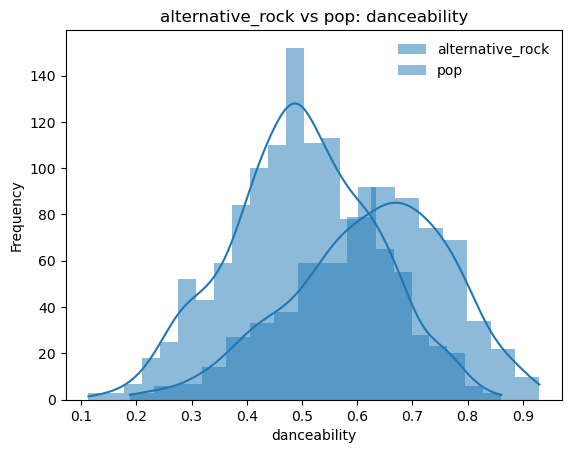

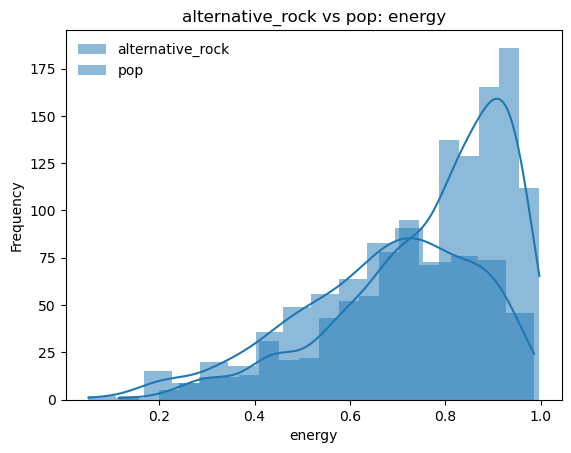

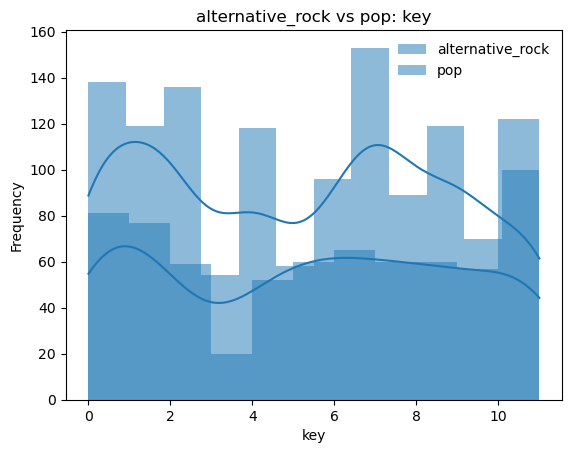

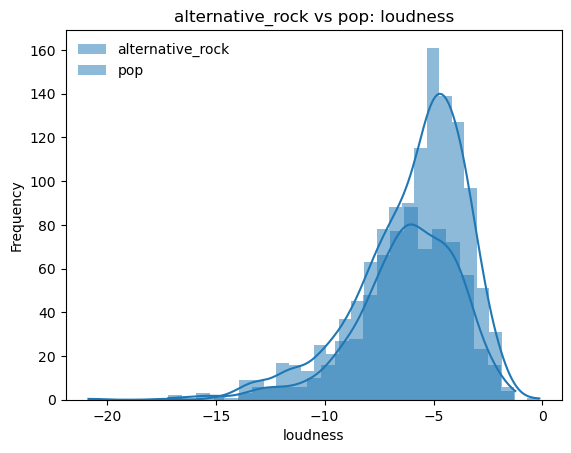

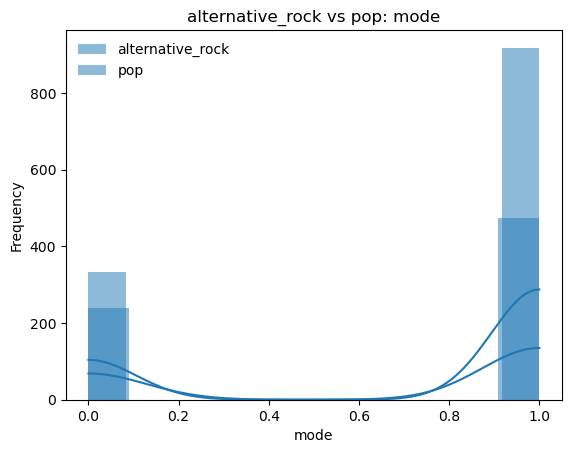

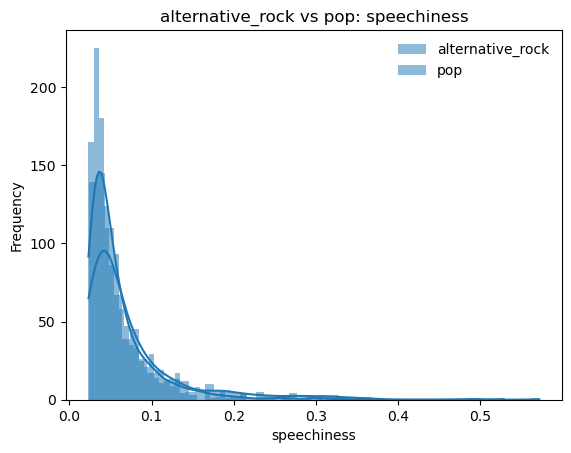

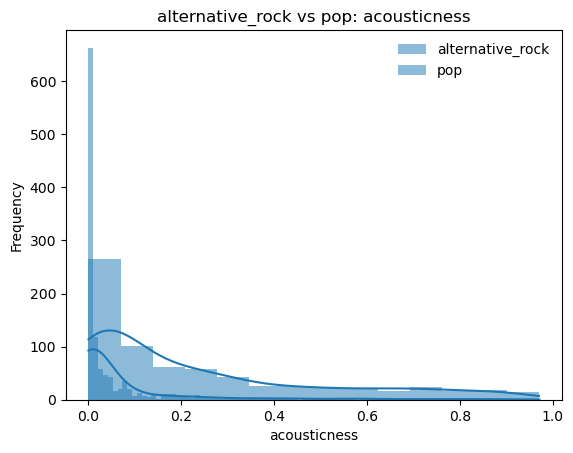

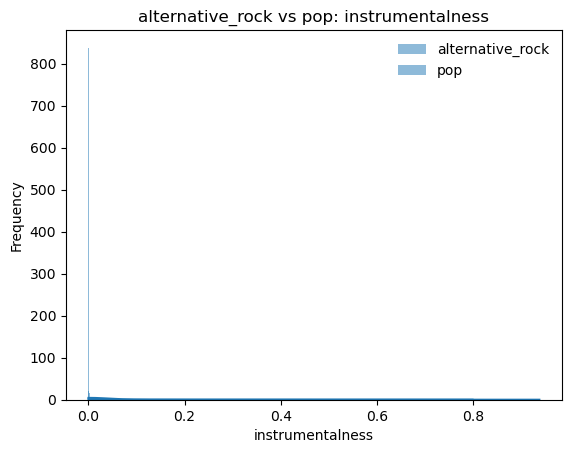

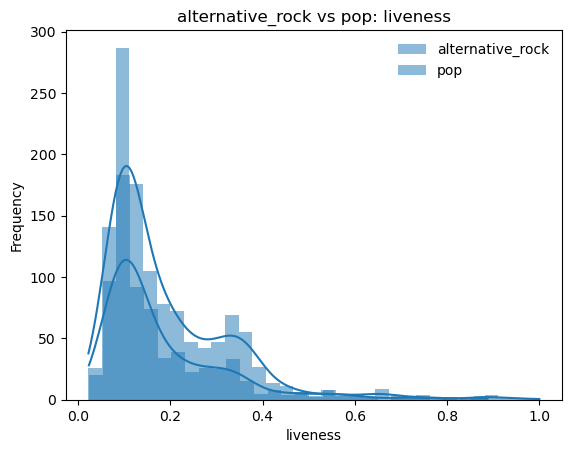

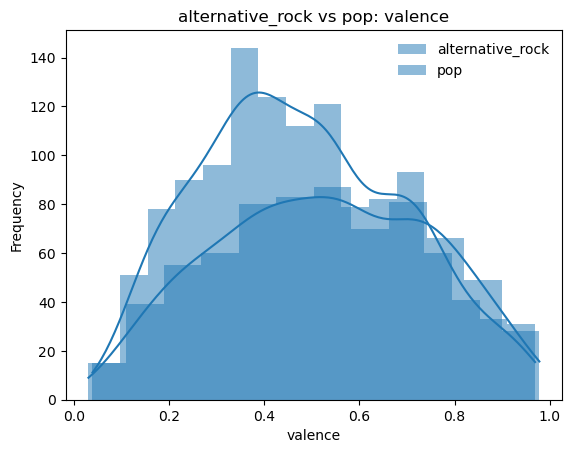

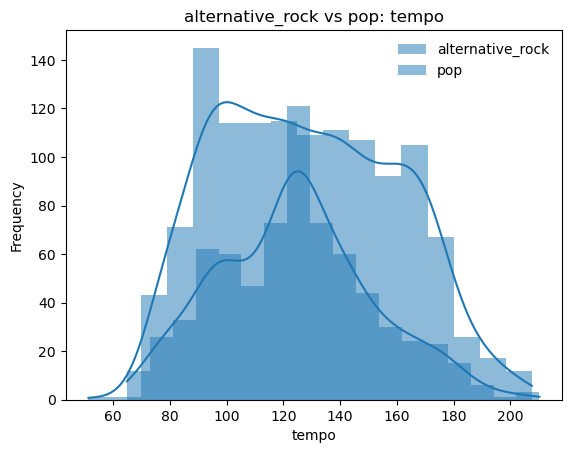

In [28]:
for col in ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']:
    fig,ax = plt.subplots()
    for genre in compare_genres:
       data = tracks_df[tracks_df['genre']==genre]
       sns.histplot(data[col], ax=ax, label= genre, kde=True, edgecolor='None')
    plt.title(f"{compare_genres[0]} vs {compare_genres[1]}: {col}")
    plt.ylabel('Frequency')
    plt.legend(frameon=False)
    plt.show()

>Q: What feature/s best distinguish the 2 categories from each other? Does it make sense to use this as a feature for a classification model?

###############################################

Explanation here

###############################################

## 3. Feature Engineering

**Categorical Encoding**
Since supervised models only takes in integers as labels, we map genres to numbers

In [29]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre,genre_id
0,2SrC3eKJkbnz4WWJufgBTS,0.488,0.870,6,-4.185,0,0.0421,0.003530,0.000000,0.484,...,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,1,4qzWf7EmJKU7SHpf38zFX0,2022-10-21,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.125333,alternative_rock,0
1,60a0Rd6pjrkxjPbaKzXjfq,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.000000,0.209,...,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,1,6hPkbAV3ZXpGZBGUvL6jVM,2000-10-24,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.614667,alternative_rock,0
2,6b2oQwSGFkzsMtQruIWm2p,0.515,0.430,7,-9.935,1,0.0369,0.010200,0.000141,0.129,...,4Z8W4fKeB5YxbusRsdQVPb,Radiohead,1,6400dnyeDyD2mIFHfkwHXN,1993-02-22,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.977333,alternative_rock,0
3,6gVH9jHl5Xpxxl4gVVrEkE,0.410,0.964,7,-6.648,1,0.0763,0.000706,0.745000,1.000,...,6olE6TJLqED3rqDCT0FyPh,Nirvana,1,01Z1nufhjxJVXVDuMRmNEM,2009-01-01,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,4.753100,alternative_rock,0
4,7AK0yeohL3m0N6l7GgzJhE,0.547,0.958,9,-2.448,0,0.1210,0.003500,0.000008,0.132,...,0avNS76kgqKRDQZWMTpQey,Hurricane on Saturn,1,76Ou6hEBhZnDymZGVIrHOD,2023-04-18,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.218333,alternative_rock,0


Build dictionary of label ids for later

In [30]:
genre_lookup = tracks_df[['genre_id','genre']].drop_duplicates()\
                        .sort_values('genre_id')\
                        .set_index('genre_id')\
                        .to_dict()['genre']
genre_lookup

{0: 'alternative_rock', 1: 'pop', 2: 'sad_opm'}

Select audio features to use for the model

In [31]:
# create feature matrix (X)
# pick energy and tempo as features
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
print(len(X),len(y))

2453 2453


Add to matrices

In [32]:
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

Split to train and test set

In [33]:
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

## 4. Train Models

In [34]:
scaler = MinMaxScaler()
sampling_reports_by_fbeta_df = load_or_run('sampling_reports_altrock_sadopm_pop_hale.csv',
                                 evaluate_sampling_techniques, X_trainval, y_trainval, scaler=scaler).sort_values(by='ave_val_acc', ascending=False)

Evaluating models with SMOTE sampling technique with MinMaxScaler...


  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.35it/s]
2it [00:01,  1.85it/s]
3it [00:01,  2.11it/s]
4it [00:01,  2.24it/s]
5it [00:02,  2.14it/s]
 14%|█▍        | 1/7 [00:02<00:14,  2.34s/it]
0it [00:00, ?it/s]
2it [00:00, 15.23it/s]
5it [00:00, 15.57it/s]
 29%|██▊       | 2/7 [00:02<00:05,  1.15s/it]
0it [00:00, ?it/s]
1it [00:00,  2.37it/s]
2it [00:00,  2.37it/s]
3it [00:01,  2.38it/s]
4it [00:01,  2.37it/s]
5it [00:02,  2.37it/s]
 43%|████▎     | 3/7 [00:04<00:06,  1.59s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:05,  2.64s/it]
3it [00:07,  2.63s/it]
4it [00:10,  2.63s/it]
5it [00:13,  2.63s/it]
 57%|█████▋    | 4/7 [00:17<00:18,  6.16s/it]
0it [00:00, ?it/s]
1it [00:00,  2.78it/s]
2it [00:00,  2.77it/s]
3it [00:01,  2.78it/s]
4it [00:01,  2.77it/s]
5it [00:01,  2.77it/s]
 71%|███████▏  | 5/7 [00:19<00:09,  4.59s/it]
0it [00:00, ?it/s]
1it [00:00,  2.30it/s]
2it [00:00,  2.32it/s]
3it [00:01,  2.34it/s]
4it [00:01,  2.34it/s]
5it [00:02,  2.33it/

Report Generated in 23.13 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler                SMOTE     99.961775   
Random Forest        MinMaxScaler                SMOTE     99.961775   
Gradient Boosting    MinMaxScaler                SMOTE     85.206399   
XGBoost              MinMaxScaler                SMOTE     99.961775   
Logistic Regression  MinMaxScaler                SMOTE     72.158485   
AdaBoost             MinMaxScaler                SMOTE     71.929145   
Decision Tree        MinMaxScaler                SMOTE     99.961775   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees            74.261308      99.961823    74.280897     99.961775   
Random Forest         73.699304      99.961823     73.85899     99.961775   
Gradient Boosting     72.833775      85.673144     73.83945     85.206399   
XGBoost               72.374981      99.961847    72.694226     99.961775   
Logi

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.44it/s]
2it [00:00,  2.40it/s]
3it [00:01,  2.42it/s]
4it [00:01,  2.39it/s]
5it [00:02,  2.39it/s]
 14%|█▍        | 1/7 [00:02<00:12,  2.09s/it]
0it [00:00, ?it/s]
2it [00:00, 12.06it/s]
5it [00:00, 12.06it/s]
 29%|██▊       | 2/7 [00:02<00:05,  1.11s/it]
0it [00:00, ?it/s]
1it [00:00,  2.27it/s]
2it [00:00,  2.25it/s]
3it [00:01,  2.27it/s]
4it [00:01,  2.27it/s]
5it [00:02,  2.28it/s]
 43%|████▎     | 3/7 [00:04<00:06,  1.60s/it]
0it [00:00, ?it/s]
1it [00:02,  2.68s/it]
2it [00:05,  2.67s/it]
3it [00:08,  2.70s/it]
4it [00:10,  2.70s/it]
5it [00:13,  2.69s/it]
 57%|█████▋    | 4/7 [00:18<00:18,  6.29s/it]
0it [00:00, ?it/s]
1it [00:00,  2.63it/s]
2it [00:00,  2.62it/s]
3it [00:01,  2.62it/s]
4it [00:01,  2.63it/s]
5it [00:01,  2.62it/s]
 71%|███████▏  | 5/7 [00:20<00:09,  4.71s/it]
0it [00:00, ?it/s]
1it [00:00,  2.21it/s]
2it [00:00,  2.20it/s]
3it [00:01,  2.19it/s]
4it [00:01,  2.19it/s]
5it [00:02,  2.19it/

Report Generated in 23.67 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler               ADASYN     99.961775   
Random Forest        MinMaxScaler               ADASYN     99.961775   
Gradient Boosting    MinMaxScaler               ADASYN     84.492926   
XGBoost              MinMaxScaler               ADASYN     99.961775   
Logistic Regression  MinMaxScaler               ADASYN     71.623339   
AdaBoost             MinMaxScaler               ADASYN     71.139303   
Decision Tree        MinMaxScaler               ADASYN     99.961775   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees            73.700473      99.961823     74.15703     99.961775   
Random Forest         73.443813      99.961823    74.181326     99.961775   
Gradient Boosting     71.711715      85.461438     73.47789     84.492926   
XGBoost               71.611232      99.961847    72.345722     99.961775   
Logi

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.46it/s]
2it [00:00,  2.45it/s]
3it [00:01,  2.45it/s]
4it [00:01,  2.45it/s]
5it [00:02,  2.45it/s]
 14%|█▍        | 1/7 [00:02<00:12,  2.04s/it]
0it [00:00, ?it/s]
2it [00:00, 15.81it/s]
5it [00:00, 15.50it/s]
 29%|██▊       | 2/7 [00:02<00:05,  1.03s/it]
0it [00:00, ?it/s]
1it [00:00,  2.40it/s]
2it [00:00,  2.41it/s]
3it [00:01,  2.43it/s]
4it [00:01,  2.43it/s]
5it [00:02,  2.42it/s]
 43%|████▎     | 3/7 [00:04<00:06,  1.51s/it]
0it [00:00, ?it/s]
1it [00:01,  1.15s/it]
2it [00:02,  1.15s/it]
3it [00:03,  1.15s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.16s/it]
 57%|█████▋    | 4/7 [00:10<00:09,  3.20s/it]
0it [00:00, ?it/s]
1it [00:00,  3.85it/s]
2it [00:00,  3.85it/s]
3it [00:00,  3.85it/s]
4it [00:01,  3.84it/s]
5it [00:01,  3.84it/s]
 71%|███████▏  | 5/7 [00:11<00:05,  2.51s/it]
0it [00:00, ?it/s]
1it [00:00,  3.07it/s]
2it [00:00,  3.07it/s]
3it [00:00,  3.07it/s]
4it [00:01,  3.06it/s]
5it [00:01,  3.06it/

Report Generated in 14.33 seconds
                          scaling resampling_technique ave_train_acc  \
Logistic Regression  MinMaxScaler             NearMiss     69.278667   
ExtraTrees           MinMaxScaler             NearMiss     83.970585   
Random Forest        MinMaxScaler             NearMiss      83.88125   
Gradient Boosting    MinMaxScaler             NearMiss     75.866758   
XGBoost              MinMaxScaler             NearMiss     82.734583   
AdaBoost             MinMaxScaler             NearMiss     64.819013   
Decision Tree        MinMaxScaler             NearMiss     80.071545   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
Logistic Regression   68.450044      70.339715    69.678669     69.278667   
ExtraTrees            65.544867      88.063088    68.988956     83.970585   
Random Forest          64.72854      87.677421    68.216336      83.88125   
Gradient Boosting     63.659449      80.533775     67.51277     75.866758   
XGBo

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.42it/s]
3it [00:00,  5.99it/s]
5it [00:00,  6.78it/s]
 14%|█▍        | 1/7 [00:00<00:04,  1.35it/s]
0it [00:00, ?it/s]
2it [00:00, 15.27it/s]
5it [00:00, 15.23it/s]
 29%|██▊       | 2/7 [00:01<00:02,  2.00it/s]
0it [00:00, ?it/s]
1it [00:00,  2.39it/s]
2it [00:00,  2.34it/s]
3it [00:01,  2.33it/s]
4it [00:01,  2.32it/s]
5it [00:02,  2.33it/s]
 43%|████▎     | 3/7 [00:03<00:05,  1.25s/it]
0it [00:00, ?it/s]
1it [00:01,  1.57s/it]
2it [00:03,  1.58s/it]
3it [00:04,  1.56s/it]
4it [00:06,  1.57s/it]
5it [00:07,  1.57s/it]
 57%|█████▋    | 4/7 [00:11<00:11,  3.86s/it]
0it [00:00, ?it/s]
1it [00:00,  3.27it/s]
2it [00:00,  3.32it/s]
3it [00:00,  3.37it/s]
4it [00:01,  3.33it/s]
5it [00:01,  3.33it/s]
 71%|███████▏  | 5/7 [00:12<00:06,  3.01s/it]
0it [00:00, ?it/s]
1it [00:00,  2.73it/s]
2it [00:00,  2.70it/s]
3it [00:01,  2.72it/s]
4it [00:01,  2.69it/s]
5it [00:01,  2.68it/s]
 86%|████████▌ | 6/7 [00:14<00:02,  2.62s/i

Report Generated in 15.74 seconds
                          scaling resampling_technique ave_train_acc  \
Gradient Boosting    MinMaxScaler           TomekLinks     85.703353   
Random Forest        MinMaxScaler           TomekLinks     93.157498   
XGBoost              MinMaxScaler           TomekLinks     93.374059   
ExtraTrees           MinMaxScaler           TomekLinks     92.864464   
Logistic Regression  MinMaxScaler           TomekLinks     73.267163   
AdaBoost             MinMaxScaler           TomekLinks      74.29918   
Decision Tree        MinMaxScaler           TomekLinks     93.144743   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
Gradient Boosting     73.903905      85.941838     73.92352     85.703353   
Random Forest         73.852365      93.434167    73.757529     93.157498   
XGBoost               73.802513      93.614512    73.801201     93.374059   
ExtraTrees             73.54819      93.181519     73.57935     92.864464   
Logi

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  8.34it/s]
2it [00:00,  8.67it/s]
3it [00:00,  8.81it/s]
4it [00:00,  8.63it/s]
5it [00:00,  8.59it/s]
 14%|█▍        | 1/7 [00:00<00:03,  1.71it/s]
0it [00:00, ?it/s]
1it [00:00,  8.64it/s]
2it [00:00,  8.87it/s]
3it [00:00,  9.04it/s]
4it [00:00,  9.29it/s]
5it [00:00,  9.26it/s]
 29%|██▊       | 2/7 [00:01<00:02,  1.78it/s]
0it [00:00, ?it/s]
1it [00:00,  2.17it/s]
2it [00:00,  2.21it/s]
3it [00:01,  2.21it/s]
4it [00:01,  2.18it/s]
5it [00:02,  2.17it/s]
 43%|████▎     | 3/7 [00:03<00:05,  1.36s/it]
0it [00:00, ?it/s]
1it [00:02,  2.60s/it]
2it [00:05,  2.60s/it]
3it [00:07,  2.59s/it]
4it [00:10,  2.60s/it]
5it [00:13,  2.61s/it]
 57%|█████▋    | 4/7 [00:16<00:17,  5.97s/it]
0it [00:00, ?it/s]
1it [00:00,  2.60it/s]
2it [00:00,  2.49it/s]
3it [00:01,  2.51it/s]
4it [00:01,  2.48it/s]
5it [00:02,  2.49it/s]
 71%|███████▏  | 5/7 [00:18<00:09,  4.54s/it]
0it [00:00, ?it/s]
1it [00:00,  2.12it/s]
2it [00:00,  2.12it/

Report Generated in 22.23 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler           SMOTETomek     97.400584   
Random Forest        MinMaxScaler           SMOTETomek     97.553474   
XGBoost              MinMaxScaler           SMOTETomek     97.502503   
Gradient Boosting    MinMaxScaler           SMOTETomek     84.849655   
Logistic Regression  MinMaxScaler           SMOTETomek     72.171232   
AdaBoost             MinMaxScaler           SMOTETomek     70.260063   
Decision Tree        MinMaxScaler           SMOTETomek     97.247693   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees            74.361791      97.413166    74.468725     97.400584   
Random Forest         73.851976      97.563404     74.08254     97.553474   
XGBoost               73.292439      97.511077    73.602369     97.502503   
Gradient Boosting     72.425611      85.294631    73.581251     84.849655   
Logi

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  8.48it/s]
2it [00:00,  7.70it/s]
3it [00:00,  7.75it/s]
4it [00:00,  7.27it/s]
5it [00:00,  7.25it/s]
 14%|█▍        | 1/7 [00:00<00:04,  1.44it/s]
0it [00:00, ?it/s]
1it [00:00,  9.64it/s]
2it [00:00,  8.50it/s]
3it [00:00,  7.73it/s]
4it [00:00,  7.90it/s]
5it [00:00,  8.02it/s]
 29%|██▊       | 2/7 [00:01<00:03,  1.53it/s]
0it [00:00, ?it/s]
1it [00:00,  2.03it/s]
2it [00:00,  2.12it/s]
3it [00:01,  2.12it/s]
4it [00:01,  2.12it/s]
5it [00:02,  2.12it/s]
 43%|████▎     | 3/7 [00:03<00:05,  1.43s/it]
0it [00:00, ?it/s]
1it [00:01,  1.82s/it]
2it [00:03,  1.83s/it]
3it [00:05,  1.80s/it]
4it [00:07,  1.80s/it]
5it [00:08,  1.80s/it]
 57%|█████▋    | 4/7 [00:12<00:13,  4.41s/it]
0it [00:00, ?it/s]
1it [00:00,  2.70it/s]
2it [00:00,  2.71it/s]
3it [00:01,  2.72it/s]
4it [00:01,  2.67it/s]
5it [00:01,  2.66it/s]
 71%|███████▏  | 5/7 [00:14<00:07,  3.50s/it]
0it [00:00, ?it/s]
1it [00:00,  2.73it/s]
2it [00:00,  2.76it/

Report Generated in 17.63 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler             SMOTEENN     76.783882   
XGBoost              MinMaxScaler             SMOTEENN     76.159581   
Random Forest        MinMaxScaler             SMOTEENN     76.185075   
Gradient Boosting    MinMaxScaler             SMOTEENN      75.53515   
Logistic Regression  MinMaxScaler             SMOTEENN     69.495455   
Decision Tree        MinMaxScaler             SMOTEENN     74.451982   
AdaBoost             MinMaxScaler             SMOTEENN     67.520608   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees             71.35639      78.521434    72.989244     76.783882   
XGBoost               70.846056      78.107946    72.863617     76.159581   
Random Forest         70.336112      78.010642    72.495876     76.185075   
Gradient Boosting     69.113439      77.654918    71.717636      75.53515   
Logi

In [35]:
sampling_reports_by_fbeta_df.to_csv('sampling_reports_minmaxscaler_altrock_pop_sadopm_hale.csv')

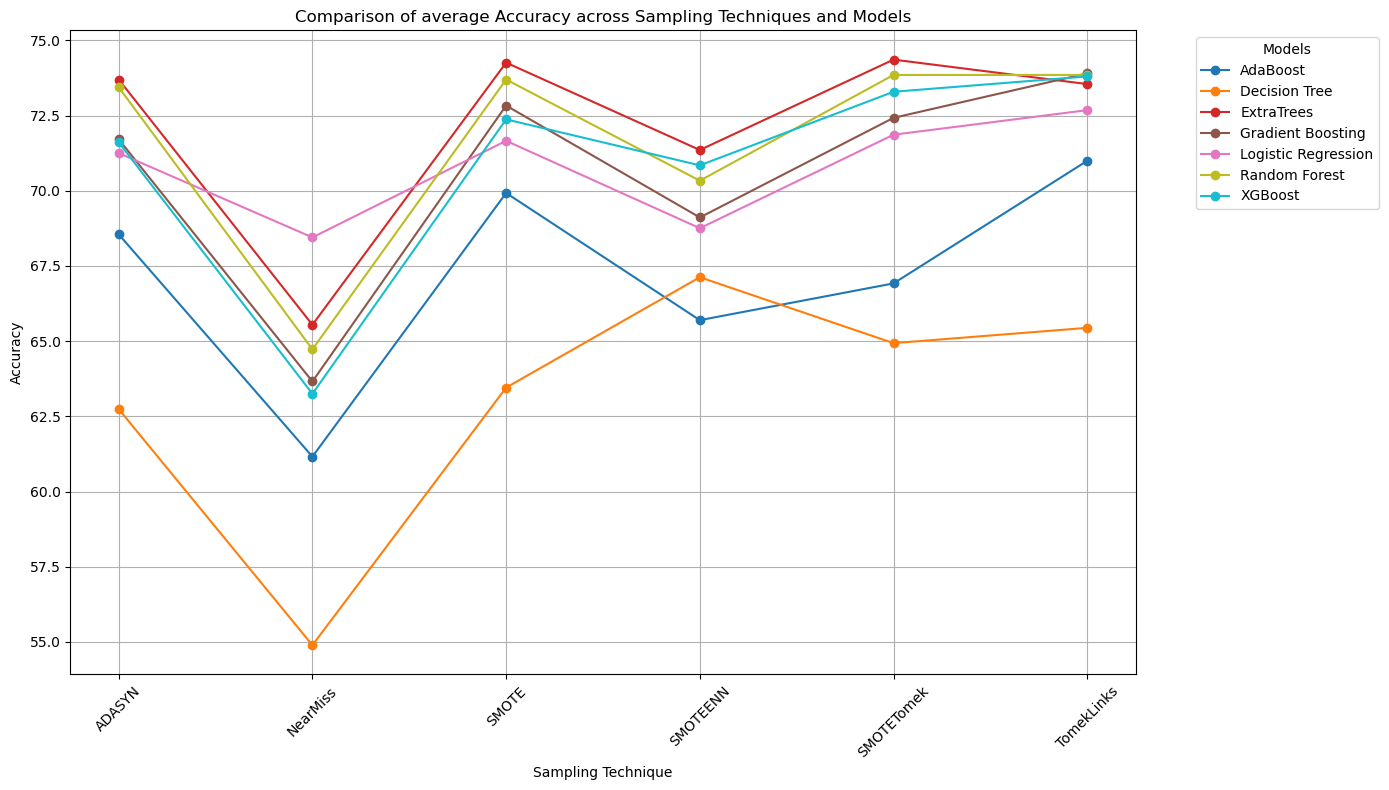

In [36]:
plot_line_comparison_models(sampling_reports_by_fbeta_df, 'ave_val_acc',
                            'Comparison of average Accuracy across Sampling Techniques and Models',
                            'Sampling Technique', 'Accuracy')

In [37]:
top5_acc = sampling_reports_by_fbeta_df.head(5).reset_index(drop=True)
display(top5_acc)

,Sampling Technique,Model,scaling,resampling_technique,ave_train_acc,ave_val_acc,ave_train_prec,ave_val_prec,ave_train_rec,ave_val_rec,ave_train_f1,ave_val_f1,run_time,results
0,SMOTETomek,ExtraTrees,MinMaxScaler,SMOTETomek,97.400584,74.361791,97.413166,74.468725,97.400584,74.361791,97.394994,74.133069,2.342359,"{'train_scores': [0.9751434034416826, 0.970681..."
1,SMOTE,ExtraTrees,MinMaxScaler,SMOTE,99.961775,74.261308,99.961823,74.280897,99.961775,74.261308,99.961766,74.024913,2.148637,"{'train_scores': [1.0, 0.9993626513702996, 0.9..."
2,TomekLinks,Gradient Boosting,MinMaxScaler,TomekLinks,85.703353,73.903905,85.941838,73.92352,85.703353,73.903905,85.548298,73.417521,7.857218,"{'train_scores': [0.8521351179094965, 0.861057..."
3,TomekLinks,Random Forest,MinMaxScaler,TomekLinks,93.157498,73.852365,93.434167,73.757529,93.157498,73.852365,93.125766,73.284221,2.147254,"{'train_scores': [0.9330783938814532, 0.930528..."
4,SMOTETomek,Random Forest,MinMaxScaler,SMOTETomek,97.553474,73.851976,97.563404,74.08254,97.553474,73.851976,97.548597,73.86016,2.308077,"{'train_scores': [0.9776927979604844, 0.970044..."


# Hyperparameter Tuning

In [39]:
top_algorithms = ['ExtraTrees', 'Gradient Boosting', 'XGBoost', 'Random Forest']
params_and_metrics = load_or_run('smotetomek_params_and_metrics_hale.csv',
                                 tune_top_models, X_trainval, y_trainval, top_algorithms, scorer=make_scorer(accuracy_score), 
                                 sampling_technique=SMOTETomek(random_state=42),
                                 n_splits=5).sort_values(by='test_accuracy', ascending=False)
display(params_and_metrics)

The top algorithms are: ['ExtraTrees', 'Gradient Boosting', 'XGBoost', 'Random Forest']
Tuning for ExtraTrees
Tuning for Gradient Boosting
Tuning for XGBoost
Tuning for Random Forest


,best_params,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_f1,val_f1,runtime
XGBoost,"{'Model__colsample_bytree': 1.0, 'Model__learn...",0.889871,0.761711,0.889871,0.761711,0.892738,0.762808,0.890044,0.762223,28.957625
ExtraTrees,"{'Model__bootstrap': False, 'Model__criterion'...",0.970088,0.755601,0.970088,0.755601,0.970337,0.752199,0.970042,0.752902,26.681225
Gradient Boosting,"{'Model__criterion': 'friedman_mse', 'Model__l...",0.919103,0.755601,0.919103,0.755601,0.922049,0.755735,0.919336,0.755623,86.93141
Random Forest,"{'Model__bootstrap': True, 'Model__criterion':...",0.890551,0.753564,0.890551,0.753564,0.893006,0.75254,0.89072,0.752991,40.043268


In [42]:
top_algorithms = ['ExtraTrees', 'Gradient Boosting', 'XGBoost', 'Random Forest']
tomeklinks_params_and_metrics = load_or_run('tomeklinks_params_and_metrics_hale.csv',
                                 tune_top_models, X_trainval, y_trainval, top_algorithms, scorer=make_scorer(accuracy_score), 
                                 sampling_technique=TomekLinks(),
                                 n_splits=5).sort_values(by='test_accuracy', ascending=False)


In [43]:
display(tomeklinks_params_and_metrics)

,Unnamed: 0,best_params,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_f1,val_f1,runtime
2,XGBoost,"OrderedDict([('Model__colsample_bytree', 0.7),...",0.878314,0.767821,0.878314,0.767821,0.882800,0.763112,0.876921,0.762030,25.794105
1,Gradient Boosting,"OrderedDict([('Model__criterion', 'friedman_ms...",0.818491,0.759674,0.818491,0.759674,0.821758,0.755683,0.816926,0.755905,50.246901
3,Random Forest,"OrderedDict([('Model__bootstrap', True), ('Mod...",0.933379,0.755601,0.933379,0.755601,0.935612,0.751486,0.932958,0.750122,30.870785
0,ExtraTrees,"OrderedDict([('Model__bootstrap', False), ('Mo...",0.889191,0.729124,0.889191,0.729124,0.892880,0.723562,0.888337,0.721003,29.512587


# Model Evaluation

In [45]:
params_and_metrics.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

,best_params,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_f1,val_f1,runtime
0,"{'Model__colsample_bytree': 1.0, 'Model__learn...",0.889871,0.761711,0.889871,0.761711,0.892738,0.762808,0.890044,0.762223,28.957625
1,"{'Model__bootstrap': False, 'Model__criterion'...",0.970088,0.755601,0.970088,0.755601,0.970337,0.752199,0.970042,0.752902,26.681225
2,"{'Model__criterion': 'friedman_mse', 'Model__l...",0.919103,0.755601,0.919103,0.755601,0.922049,0.755735,0.919336,0.755623,86.93141
3,"{'Model__bootstrap': True, 'Model__criterion':...",0.890551,0.753564,0.890551,0.753564,0.893006,0.75254,0.89072,0.752991,40.043268


In [47]:
params_and_metrics.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True).best_params[0]

OrderedDict([('Model__colsample_bytree', 1.0),
             ('Model__learning_rate', 0.01),
             ('Model__max_depth', 9),
             ('Model__n_estimators', 150),
             ('Model__subsample', 0.5)])

In [48]:
from collections import OrderedDict
best_params = params_and_metrics.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True).best_params[0]
best_params = OrderedDict((k.replace('Model__', ''), v) for k, v in best_params.items())
best_params

OrderedDict([('colsample_bytree', 1.0),
             ('learning_rate', 0.01),
             ('max_depth', 9),
             ('n_estimators', 150),
             ('subsample', 0.5)])

Classification Report:
                  precision    recall  f1-score   support

alternative_rock       0.83      0.76      0.79       250
             pop       0.64      0.59      0.62       143
         sad_opm       0.63      0.83      0.72        98

        accuracy                           0.73       491
       macro avg       0.70      0.73      0.71       491
    weighted avg       0.73      0.73      0.73       491

Confusion Matrix:
[[191  39  20]
 [ 31  85  27]
 [  9   8  81]]


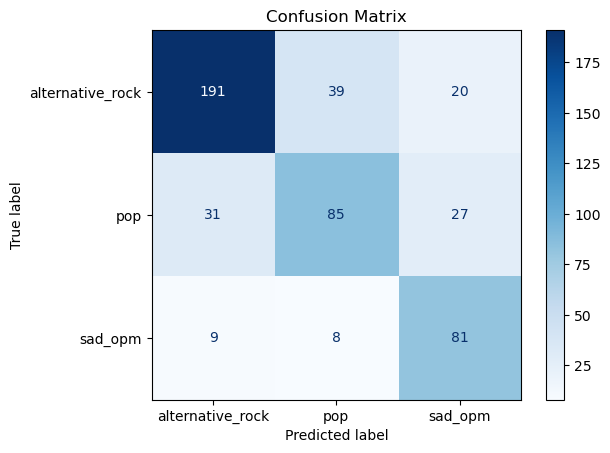

Training Accuracy: 0.9072375127420998
Testing Accuracy: 0.7270875763747454
Training Recall: 0.9072375127420998
Test Recall: 0.7270875763747454
Precision: 0.7348450408213646
F1 Score: 0.7274796052043137


In [50]:
best_params['random_state'] = 42
best_model = xgb.XGBClassifier(**best_params)

pipeline, test_accuracy = evaluate_model(best_model, X_trainval, y_trainval, X_holdout, y_holdout, scaler=MinMaxScaler(),
                            sampling_technique=SMOTE(random_state = 42), features=None,  target_names=genre_lookup.values(), filename='gradientboosting_smote_allfeats_final')

In [51]:
best_model_pipeline = pipeline

best_model = best_model_pipeline.named_steps['model']
best_model_scaler = best_model_pipeline.named_steps['scaler']

In [52]:
tracks_df['predicted_genre_id'] = best_model_pipeline.predict(tracks_df[feature_cols])
tracks_df['predicted_genre'] = tracks_df['predicted_genre_id'].map(genre_lookup)
tracks_df

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre,genre_id,predicted_genre_id,predicted_genre
0,2SrC3eKJkbnz4WWJufgBTS,0.488,0.870,6,-4.185,0,0.0421,0.003530,0.000000,0.4840,...,1,4qzWf7EmJKU7SHpf38zFX0,2022-10-21,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.125333,alternative_rock,0,0,alternative_rock
1,60a0Rd6pjrkxjPbaKzXjfq,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.000000,0.2090,...,1,6hPkbAV3ZXpGZBGUvL6jVM,2000-10-24,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.614667,alternative_rock,0,0,alternative_rock
2,6b2oQwSGFkzsMtQruIWm2p,0.515,0.430,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,...,1,6400dnyeDyD2mIFHfkwHXN,1993-02-22,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.977333,alternative_rock,0,0,alternative_rock
3,6gVH9jHl5Xpxxl4gVVrEkE,0.410,0.964,7,-6.648,1,0.0763,0.000706,0.745000,1.0000,...,1,01Z1nufhjxJVXVDuMRmNEM,2009-01-01,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,4.753100,alternative_rock,0,0,alternative_rock
4,7AK0yeohL3m0N6l7GgzJhE,0.547,0.958,9,-2.448,0,0.1210,0.003500,0.000008,0.1320,...,1,76Ou6hEBhZnDymZGVIrHOD,2023-04-18,23wVfSXsUtP9z94e1jMjeQ,Alternative Rock 90s 2000s - Best Alternative ...,3.218333,alternative_rock,0,0,alternative_rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6851,66FQlENQhffJNXm8Ae4KIg,0.592,0.659,8,-7.177,1,0.0745,0.027700,0.007740,0.1180,...,1,338nJ7kiXQww30TUql5VjC,2022-11-11,37i9dQZF1DWWEcRhUVtL8n,Indie Pop,3.659700,pop,1,1,pop
6852,520Ri2FiyuSI9qw1XP0CA3,0.586,0.754,11,-6.487,1,0.0339,0.056900,0.002700,0.0794,...,1,2YszPdalHkFnXxqMPrHlhm,2023-07-14,37i9dQZF1DWWEcRhUVtL8n,Indie Pop,2.765267,pop,1,1,pop
6853,66Ew9TmVnxjg8HTjsFoSts,0.529,0.578,8,-7.853,1,0.0272,0.498000,0.046700,0.1080,...,1,7asv9hl6KprOE0AR0kubiL,2023-04-07,37i9dQZF1DWWEcRhUVtL8n,Indie Pop,3.440450,pop,1,1,pop
6854,0vbqjI3TKufY0I33RtdXFD,0.653,0.713,6,-6.587,1,0.0511,0.600000,0.000125,0.0843,...,1,7FghAqLEF3Qvjv91tcwKTc,2023-10-06,37i9dQZF1DWWEcRhUVtL8n,Indie Pop,3.549467,pop,1,1,pop


In [53]:
joblib.dump(best_model_pipeline,'genre_classifier_hale_smotetomek_xgboost.pkl')

['genre_classifier_hale_smotetomek_xgboost.pkl']

## 6. Feature Importance

Use scaler from pipeline to transform

In [ ]:
features = best_model_scaler.transform(X_train)

Run SHAP explainer and get importance values

In [ ]:
explainer = shap.TreeExplainer(best_model,\
                            feature_names=feature_cols)
shap_values = explainer.shap_values(features)

KeyboardInterrupt: ignored

In [ ]:
shap.summary_plot(shap_values=shap_values,
                  features = features,
                  feature_names = feature_cols,
                  class_names = list(genre_lookup.values()),
                  plot_type = "bar")

>Q: Pick a track and verify as a listener if you agree with the predicted genre and how shap explains it

In [ ]:
# Get sample track and index, scale features
sample = tracks_df[tracks_df['track_name'].str.contains('Under Pressure')]
sample_idx = sample.index.values[0]
sample_features = best_model_scaler.transform(sample[feature_cols])
sample

In [ ]:
# Plot force plot per genre
shap_values = explainer.shap_values(sample_features)
shap.initjs()
for genre_id in range(8):
    print(genre_lookup[genre_id])
    display(shap.force_plot(explainer.expected_value[genre_id], shap_values[genre_id], sample_features,\
                             feature_names=feature_cols))


## 7. Check misclassfied tracks in training data

>Q: How many tracks had different tagged and predicted genres?

In [ ]:
tracks_df[tracks_df['genre_id'] != tracks_df['predicted_genre_id']]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id,predicted_genre_id,predicted_genre
5,6nTcn8CybBcx0t7IaXEJ6O,Thank God I Found You (feat. Joe & Nas) - Make...,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6zuCJaxmHKNKN5hMDF556U,251640,2000-04-18,60,0.608,0.760,...,0.000000,0.332,0.366,168.211,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,4,6,reggae
13,5Y77SQxEr1eiofPeUTPHxM,You,1Xfmvd48oOhEWkscWyEbh9,Lloyd,6Lq7nLkIq7C0zVJp0OGSGO,273133,2007-01-01,71,0.412,0.876,...,0.000000,0.297,0.703,130.159,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,4,5,rap
24,3s2MyU2YCwNNwcSokt0jXD,Girl,1Y8cdNmUJH7yBTd9yOvr5i,Destiny's Child,0b6ivSFfDs38MG7aLn9rvO,224146,2004-11-16,63,0.567,0.747,...,0.000000,0.040,0.556,89.036,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,4,1,country
32,02QQXgeAghpU4smdM7l7We,Spotlight,35GL8Cu2GKTcHzKGi75xl5,Jennifer Hudson,6RCEPR3vf58GQTK2sT1cQP,250106,2008-09-30,62,0.707,0.724,...,0.000000,0.072,0.659,108.984,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,4,6,reggae
37,3SfZpKjMwvUQKGCty1dJ0T,"Slow Down - 12"" Version",4HgF4KnohByNElYid7iCNb,Bobby V.,5D7khI4iB1RseZNgoBQPLi,258666,2005-01-01,0,0.563,0.746,...,0.000006,0.338,0.598,186.118,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,4,6,reggae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,45DQtZwQ8ycqJ31TaYk8Ax,Cruz de tecido,1A5QJAC1vdhbhPE25Q0x0f,O Rappa,6Dlr7qx33gN0uUahMs9u2a,376933,2013-08-15,49,0.486,0.855,...,0.005460,0.108,0.464,173.024,37i9dQZF1DWXfi2vTRVTna,This Is O Rappa,rap,5,7,rock
730,408HrdQ738YjLnovSTOUAg,Hóstia,1A5QJAC1vdhbhPE25Q0x0f,O Rappa,7K1joBbwsVnvP3pViv8UJr,203240,2008-07-29,51,0.591,0.689,...,0.000005,0.142,0.851,164.961,37i9dQZF1DWXfi2vTRVTna,This Is O Rappa,rap,5,6,reggae
731,11iLxpjYxcq3aDqzqUcYy0,Lado B lado A,1A5QJAC1vdhbhPE25Q0x0f,O Rappa,3I1bOo70cU0y7PprxCGgAs,305226,1999-01-01,51,0.752,0.827,...,0.000013,0.316,0.463,107.498,37i9dQZF1DWXfi2vTRVTna,This Is O Rappa,rap,5,2,electronic
736,6dMLoNGV0csf6zr9lbbfIv,Um dia lindo - Participação especial de Edi Rock,1A5QJAC1vdhbhPE25Q0x0f,O Rappa,6Dlr7qx33gN0uUahMs9u2a,370213,2013-08-15,47,0.591,0.881,...,0.001020,0.358,0.531,102.026,37i9dQZF1DWXfi2vTRVTna,This Is O Rappa,rap,5,7,rock


Pick one among these tracks and use `shap.force_plot` to understand why the model classified it to another genre

In [ ]:
sample = tracks_df[tracks_df['genre_id'] != tracks_df['predicted_genre_id']].sample(1)
sample_idx = sample.index.values[0]
sample_features = best_model_scaler.transform(sample[feature_cols])
print(sample.iloc[0])

track_id                        3olGkpomYOWwRZsbFTZqiX
track_name            Devil Always Made Me Think Twice
artist_id                       4YLtscXsxbVgi031ovDDdh
artist_name                            Chris Stapleton
album_id                        0sOeI7pbAmIc8aDFyvkBUW
duration                                        231720
release_date                                2020-11-13
popularity                                          66
danceability                                     0.729
energy                                           0.685
key                                                  7
loudness                                        -7.547
mode                                                 1
speechiness                                       0.03
acousticness                                     0.358
instrumentalness                                0.0102
liveness                                         0.111
valence                                           0.56
tempo     